#### The first code cell loads the various Python libraries required for the problem

**Numpy** (Numerical Python) is a Python library used for scientific computing and numerical operations. It provides support for handling arrays and matrices (tensors) and a wide-variety of mathematical functions.

**Matplotlib** is a Python library for plotting data. It is widely used for data visualization in scientific computing, data analysis, and machine learning.

**TensorFlow** is an open-source machine learning and deep learning framework developed by Google. It provides a platform for building and deploying machine learning models, including neural networks and deep learning applications.

**Keras** is an open-source deep learning library that provides a high-level, user-friendly API for building and training neural networks. It is written in Python and runs on top of TensorFlow.

**Scikit-Learn (sklearn)** is a machine learning library for Python that provides simple and efficient tools for data mining, analysis, and predictive modeling. It is built on NumPy, SciPy, and Matplotlib

**Pandas** is an open-source Python library used for data manipulation, analysis, and processing. It provides easy-to-use data structures like DataFrames, making it essential for handling structured data.

**Seaborn** is a Python data visualization library built on top of Matplotlib. It provides a high-level API for creating more attractive and informative statistical graphics.

**h5py** is a Python library that provides an interface to HDF5 (Hierarchical Data Format version 5) files, which are used for storing large amounts of structured data efficiently.

**os** allows access to the operating system.

In [ ]:
# Core imports
import os
import zipfile
import requests
from io import BytesIO

# Scientific libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, Model, utils, mixed_precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)

# Other utilities
import h5py
from PIL import Image
from IPython.display import display, HTML

# Set mixed precision policy
mixed_precision.set_global_policy('mixed_float16')

# Adjust notebook output window height
display(HTML("<style>div.output_scroll { height: 54em; }</style>"))


Load dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/

[Errno 2] No such file or directory: 'drive/MyDrive/'
/content/drive/MyDrive


In [ ]:
h5_file = h5py.File('Galaxy10_DECals.h5', 'r')
images = h5_file['images'][:]  # (N, H, W, C)
labels = h5_file['ans'][:] if 'ans' in h5_file else None

print(f"Loaded {images.shape[0]} images")

Loaded 17736 images


In [ ]:
images.shape

(17736, 256, 256, 3)

#### Now we split the data set into a training set, validation set and a test set. The test set is used to test the CNN after it has been trained. The validation set is used to validate the CNN during training, and is useful to test for overfitting.

#### X_train is an array containing 17736 images, each represented by a 256x256x3 array corresponding to 256x256 pixels and 3 colour channels. X_val and X_test are arrays containing 1774 and 1774 test images, respectively. Note we renormlise the pixel values so they are in the range [0.,1.]

In [ ]:
# First, split the data into a training set and a temporary set, where the temporary set contains 20% of the images
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2)
# Second, split the temporary set into validation and test sets of equal size
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

X_train = X_train/255
X_test = X_test/255
X_val = X_val/255

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train.dtype, X_val.dtype, X_test.dtype)

(14188, 256, 256, 3) (1774, 256, 256, 3) (1774, 256, 256, 3)
float64 float64 float64


In [ ]:
del images
del labels

#### We now define a list of labels for the images that will be useful later and assign the list to the variable "galaxy_classes".

#### We then plot/display the first 25 images in the training data set to see what they look like, using their labels in each plot title

In [ ]:
# Define a list containing the labels in string format
galaxy_classes = [
    "Disturbed Galaxies",                     # Class 0
    "Merging Galaxies",                       # Class 1
    "Round Smooth Galaxies",                  # Class 2
    "In-between Round Smooth Galaxies",       # Class 3
    "Cigar Shaped Smooth Galaxies",           # Class 4
    "Barred Spiral Galaxies",                 # Class 5
    "Unbarred Tight Spiral Galaxies",         # Class 6
    "Unbarred Loose Spiral Galaxies",         # Class 7
    "Edge-on Galaxies without Bulge",         # Class 8
    "Edge-on Galaxies with Bulge"             # Class 9
]

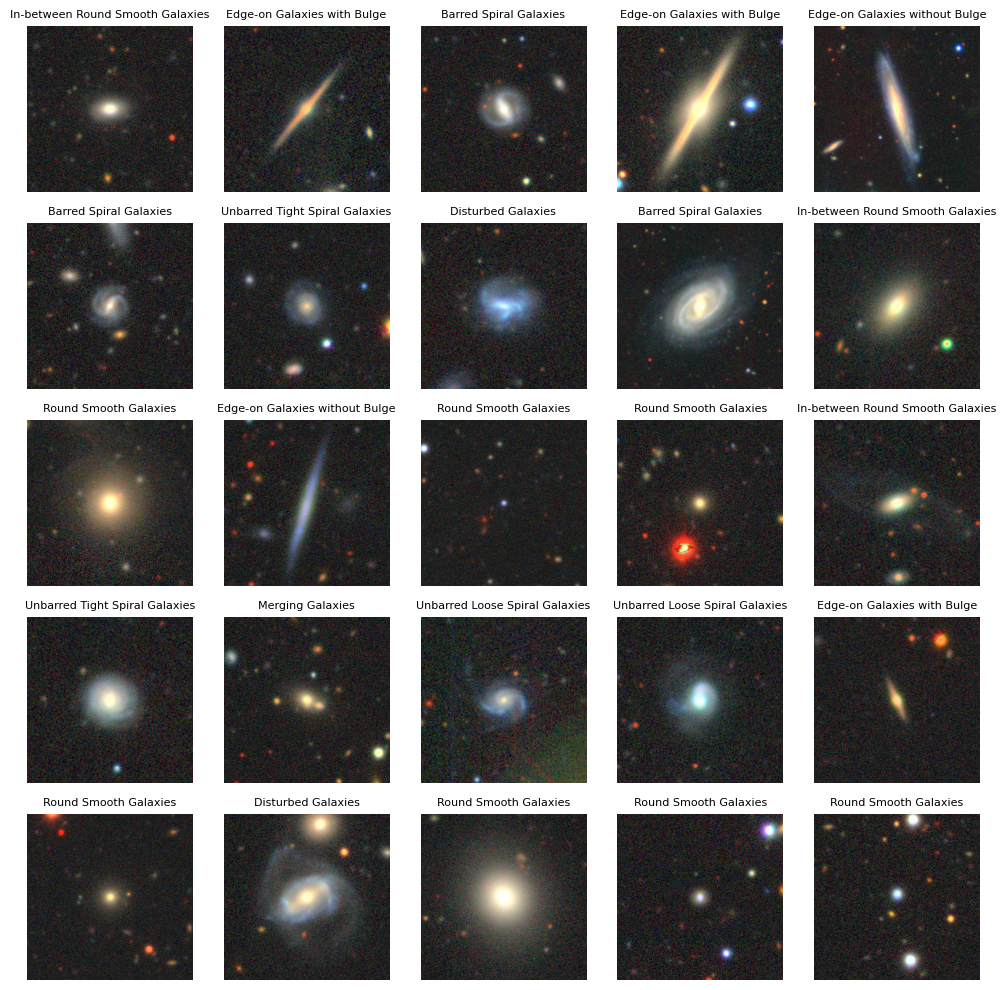

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(galaxy_classes[y_train[i]],fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

check data distribution

In [ ]:
classes, counts = np.unique(y_train, return_counts=True)

# Display class distribution
for cls, count in zip(classes, counts):
    print(f"Class {cls}: {count} samples ({count / len(y_train) * 100:.2f}%)")

# Optional: Check imbalance ratio
imbalance_ratio = counts.max() / counts.min()
print(f"\nImbalance Ratio (max/min): {imbalance_ratio:.2f}")

Class 0: 879 samples (6.20%)
Class 1: 1486 samples (10.47%)
Class 2: 2148 samples (15.14%)
Class 3: 1606 samples (11.32%)
Class 4: 278 samples (1.96%)
Class 5: 1635 samples (11.52%)
Class 6: 1476 samples (10.40%)
Class 7: 2069 samples (14.58%)
Class 8: 1115 samples (7.86%)
Class 9: 1496 samples (10.54%)

Imbalance Ratio (max/min): 7.73


In [ ]:
def preprocess_image(img):
    img = img*255
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    return img/255

#### Below is a Data Generator that can be used to feed data into the model training in batches

In [ ]:
# # Batch Generator for feeding images into model training
class BatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=64, shuffle=True):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(images))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indices = self.indices[start:end]
        batch_images = np.array([preprocess_image(x) for x in self.images[batch_indices]])
        return batch_images, self.labels[batch_indices]

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
# Create generators for all three datasets
train_generator = BatchGenerator(X_train, y_train)
val_generator = BatchGenerator(X_val, y_val)
test_generator = BatchGenerator(X_test, y_test)

Load pretrained DenseNet model using Imagenet weights

In [ ]:
base_model = keras.applications.DenseNet121(weights ='imagenet', include_top = False, input_shape = (256,256,3))

In [ ]:
base_model.output

<KerasTensor shape=(None, 8, 8, 1024), dtype=float16, sparse=False, name=keras_tensor_858>

In [ ]:
x=base_model.output

Add global avg pooling and classification layers

In [ ]:
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(10, activation = 'softmax')(x)

Define early stopping callback

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5)

Compile model using adam optimiser and Categorical Cross Entropy Loss

In [ ]:
head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer=Adam(), loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

Model training for 50 epochs and batch size 64

In [ ]:
history = head_model.fit(train_generator,validation_data = val_generator,batch_size=64,epochs=50,callbacks=[es])

Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step - accuracy: 0.4808 - loss: 1.6892 - val_accuracy: 0.4696 - val_loss: 1.8547
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 96s 431ms/step - accuracy: 0.7353 - loss: 0.7893 - val_accuracy: 0.6629 - val_loss: 1.4472
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 96s 433ms/step - accuracy: 0.7856 - loss: 0.6444 - val_accuracy: 0.7593 - val_loss: 0.7439
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 94s 421ms/step - accuracy: 0.8064 - loss: 0.5678 - val_accuracy: 0.7723 - val_loss: 0.7224
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 94s 425ms/step - accuracy: 0.8107 - loss: 0.5553 - val_accuracy: 0.7559 - val_loss: 0.7338
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 94s 425ms/step - accuracy: 0.8230 - loss: 0.5219 - val_accuracy: 0.7339 - val_loss: 0.8005
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 96s 431ms/step - accuracy: 0.8367 - loss: 0.4706 - val_accuracy: 0.7926 - val_loss: 0.6416
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 93s 419ms/step - accuracy: 0.8382 - loss: 0.4

Metrics

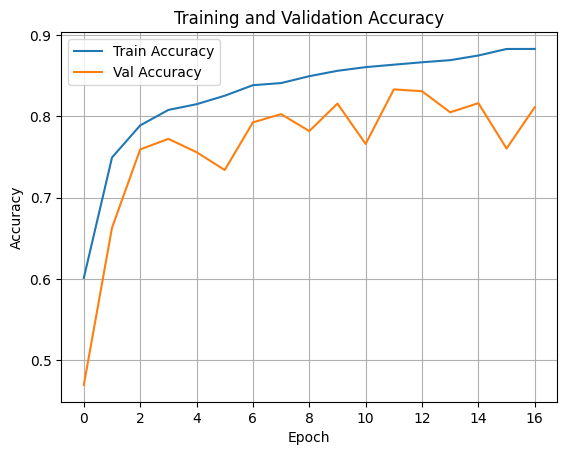

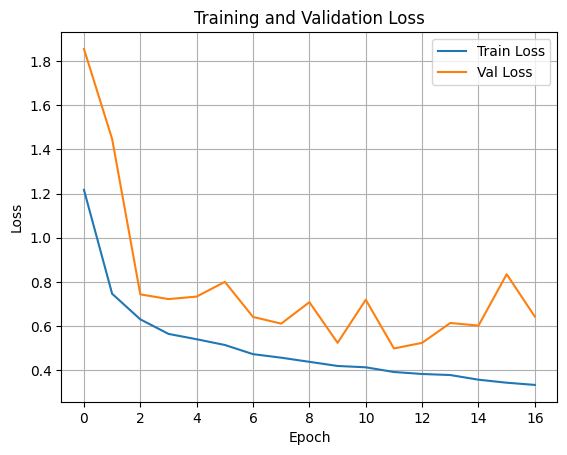

In [ ]:


# Assuming you did:
# history = model.fit(...)

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
y_true = y_test
y_pred = head_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

56/56 ━━━━━━━━━━━━━━━━━━━━ 37s 328ms/step


In [ ]:
acc = accuracy_score(y_test, y_pred_labels)
print(acc)

0.8156708004509583


In [ ]:

target_names = galaxy_classes

report = classification_report(y_true, y_pred_labels, target_names=target_names)
print(report)


                                  precision    recall  f1-score   support

              Disturbed Galaxies       0.44      0.49      0.47       102
                Merging Galaxies       0.93      0.85      0.89       197
           Round Smooth Galaxies       0.96      0.89      0.93       246
In-between Round Smooth Galaxies       0.90      0.95      0.93       204
    Cigar Shaped Smooth Galaxies       0.70      0.82      0.76        34
          Barred Spiral Galaxies       0.87      0.85      0.86       203
  Unbarred Tight Spiral Galaxies       0.80      0.56      0.66       189
  Unbarred Loose Spiral Galaxies       0.63      0.84      0.72       283
  Edge-on Galaxies without Bulge       0.95      0.84      0.89       148
     Edge-on Galaxies with Bulge       0.94      0.86      0.90       168

                        accuracy                           0.82      1774
                       macro avg       0.81      0.80      0.80      1774
                    weighted avg    

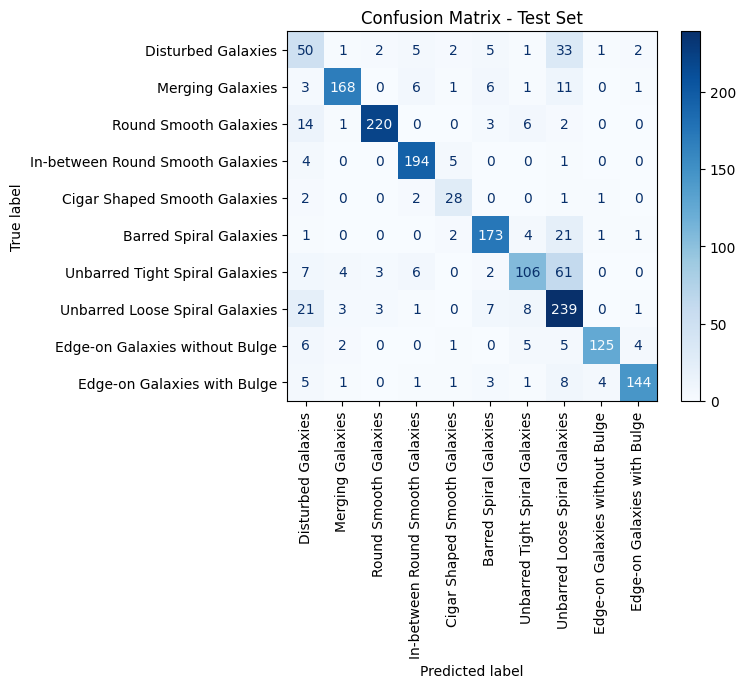

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Optional: class names if you have them
class_names = [str(i) for i in range(cm.shape[0])]  # or your actual label names

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=galaxy_classes)
disp.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix - Test Set")

plt.show()

Baseline model

#### Build the Convolutional Neural Network (CNN) model

In [ ]:
model_CNN = keras.Sequential([
    # Input layer
    keras.layers.Input(shape=(256,256,3)),

    # First Convolutional Layer
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),  # Max Pooling

    # Second Convolutional Layer
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),  # Max Pooling

    # Flatten the feature maps before feeding into the dense layer(s)
    keras.layers.Flatten(),

    # Fully Connected Layer (Dense)
    keras.layers.Dense(units=128, activation='relu'),

    # Output Layer (Softmax for multi-class classification)
    keras.layers.Dense(units=10, activation='softmax')
])

#### Compile the model

In [ ]:
model_CNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history =model_CNN.fit(X_train,y_train,validation_data = (X_val,y_val),epochs=50,callbacks=[es])

#### Train the model and store information about how the accuracy and loss functions change with each epoch/iteration in the variable "history". Note the use of the data generators to feed data during the training process. Ignore the warning messages appearing in pink.

#### Evaluate the accuracy of the model using the test set and store the values of loss function and the accuracy

In [ ]:
test_loss, test_acc = model_CNN.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

#### We see the acccuracy of the model in identifying the correct galaxy types in the test images is decent but not at the 90% level

#### We now plot the training and validation accuracy and loss functions to check for overfitting

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(7,3))
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].set_title('Training vs Validation Accuracy')

axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].set_title('Training vs Validation Loss')
plt.tight_layout()

#### We now use the model to make predictions about the galaxy types in the images using the test dataset and we display a sample prediction and compare it with the actual class

In [ ]:
predictions = model_CNN.predict(X_test).argmax(axis=1)
predictions2 = model_CNN.predict(X_test)
print("")
print("predictions2[0] = ",predictions2[0])
print("")
print('Predicted class = ',galaxy_classes[predictions[0]])
print('Actual class = ',galaxy_classes[y_test[0]])
# Display a sample prediction
plt.figure(figsize=(3,3))
plt.imshow(X_test[0].astype('float32'))
plt.title(f"{galaxy_classes[predictions[0]]}")
plt.show()

#### We now plot the confusion matrix which graphically compares the predictions versus the actual classifications.

In [ ]:
matrix = confusion_matrix(y_test, predictions)
sns.heatmap((matrix), annot=True, annot_kws={"size": 7})
plt.title('Galaxy10 Confusion Matrix for CNN')
plt.xlabel('Predicted class')
plt.ylabel('True class')

#### One thing to be aware of is that the predictions can change slightly each time you run a model. This is because the weights are initialised randomly and optimizers such as Adam use stochastic gradient descent methods.

#### We now construct a classification report comparing the labels for the test dataset against the predictions made by the model. We output the report as a dictionary, which allows us to format the output into a more readable form using a pandas data frame.

In [ ]:
report=classification_report(y_test, predictions,output_dict=True,zero_division=1)

In [ ]:
df=pd.DataFrame(report).transpose()
print(df)

In [ ]:
# Here we append empty spaces to the list of object
# classes contained in "features" so we can add them
# to the dataframe below.
features2=features[:]
features2.append('')
features2.append('')
features2.append('')

In [ ]:
# Here we add the list classes to the dataframe
df["Class"]=features2

In [ ]:
print(df[["Class","precision","recall","support"]])